# Compute necessary data

In [88]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

pd.set_option('display.max_rows', None)

def fix_encoding(title):
    return bytes(title, "latin1").decode("utf8")

In [89]:
d = pd.read_sql("""
    select
        event_log.id as event_log_id,
        event_log.date,
        user.id as user_id,
        event.id as event_id,
        event.name as event_name,
        user.username,
        event_log.uuid_id as uuid,
        uuid.trashed as uuid_trashed,
        uuid.discriminator as uuid_type
    from event_log
    join user on user.id = event_log.actor_id
    join event on event.id = event_log.event_id
    join uuid on uuid.id = event_log.uuid_id
    where year(event_log.date) >= 2018
    order by event_log.id
""", db)
d.set_index("event_log_id", inplace=True)
d.head()

,date,user_id,event_id,event_name,username,uuid,uuid_trashed,uuid_type
event_log_id,,,,,,,,
193359,2018-01-01 14:08:08,28,9,discussion/comment/create,petersi,93378,0,comment
193360,2018-01-01 15:36:17,62384,5,entity/revision/add,Rebi,93379,0,entityRevision
193361,2018-01-01 15:36:17,62384,6,entity/revision/checkout,Rebi,93379,0,entityRevision
193362,2018-01-01 15:38:00,62384,5,entity/revision/add,Rebi,93380,0,entityRevision
193363,2018-01-01 15:38:00,62384,6,entity/revision/checkout,Rebi,93380,0,entityRevision


In [90]:
def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return fix_encoding(querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0])

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    parents = query(f"""
        select parent_id, uuid_id from comment
        where comment.id  = {uuid};
    """)
    
    if len(parents) > 0:
        parent_id, uuid_id = parents[0]
        
        if parent_id:
            return getSubjectFromUuid(parent_id)
        else:
            return getSubjectFromUuid(uuid_id)
    
    parents = querySingleton(f"""
        select repository_id from entity_revision
        where entity_revision.id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

display(getSubjectFromUuid(127338))
display(getSubjectFromUuid(63496))
display(getSubjectFromUuid(1))
display(getSubjectFromUuid(170741))
display(getSubjectFromUuid(167497))
display(getSubjectFromUuid(93379))
display(getSubjectFromUuid(93387))

'Chemie'

'Chemie'

None

'Mathe'

'Testbereich!'

'Prüfungsbereich Mathematik'

'Mathe'

In [91]:
d["subject"] = d["uuid"].map(getSubjectFromUuid)
d.head()

,date,user_id,event_id,event_name,username,uuid,uuid_trashed,uuid_type,subject
event_log_id,,,,,,,,,
193359,2018-01-01 14:08:08,28,9,discussion/comment/create,petersi,93378,0,comment,None
193360,2018-01-01 15:36:17,62384,5,entity/revision/add,Rebi,93379,0,entityRevision,Prüfungsbereich Mathematik
193361,2018-01-01 15:36:17,62384,6,entity/revision/checkout,Rebi,93379,0,entityRevision,Prüfungsbereich Mathematik
193362,2018-01-01 15:38:00,62384,5,entity/revision/add,Rebi,93380,0,entityRevision,Prüfungsbereich Mathematik
193363,2018-01-01 15:38:00,62384,6,entity/revision/checkout,Rebi,93380,0,entityRevision,Prüfungsbereich Mathematik


In [92]:
def event_category(row):
    # mysql> select * from event;
    # +----+-----------------------------+-------------+
    # | id | name                        | description |
    # +----+-----------------------------+-------------+
    # |  1 | taxonomy/term/associate     | NULL        |
    # |  2 | taxonomy/term/create        | NULL        |
    # |  3 | license/object/set          | NULL        |
    # |  4 | entity/create               | NULL        |
    # |  5 | entity/revision/add         | NULL        |
    # |  6 | entity/revision/checkout    | NULL        |
    # |  7 | entity/link/create          | NULL        |
    # |  8 | discussion/create           | NULL        |
    # |  9 | discussion/comment/create   | NULL        |
    # | 10 | uuid/trash                  | NULL        |
    # | 11 | entity/revision/reject      | NULL        |
    # | 12 | taxonomy/term/update        | NULL        |
    # | 13 | uuid/restore                | NULL        |
    # | 14 | discussion/comment/archive  | NULL        |
    # | 15 | taxonomy/term/parent/change | NULL        |
    # | 16 | discussion/restore          | NULL        |
    # | 17 | taxonomy/term/dissociate    | NULL        |
    # | 18 | entity/link/remove          | NULL        |
    # +----+-----------------------------+-------------+
    
    event_id, uuid_type = row[0], row[1]
    
    if event_id in [10,13] and uuid_type =="comment":
        return "moderation"
    elif event_id in [1,2,7, 12,15, 17, 18]:
        return "taxonomy"
    elif event_id in [4,5]:
        return "edit"
    elif event_id in [11,6]:
        return "review"
    elif event_id in [14,16]:
        return "moderation"
    elif event_id in [8,9]:
        return "comment"
    elif event_id in [10, 13, 3]:
        return "admin"

d["event_category"] = d[["event_id", "uuid_type"]].apply(event_category, axis=1)
d.head()

,date,user_id,event_id,event_name,username,uuid,uuid_trashed,uuid_type,subject,event_category
event_log_id,,,,,,,,,,
193359,2018-01-01 14:08:08,28,9,discussion/comment/create,petersi,93378,0,comment,None,comment
193360,2018-01-01 15:36:17,62384,5,entity/revision/add,Rebi,93379,0,entityRevision,Prüfungsbereich Mathematik,edit
193361,2018-01-01 15:36:17,62384,6,entity/revision/checkout,Rebi,93379,0,entityRevision,Prüfungsbereich Mathematik,review
193362,2018-01-01 15:38:00,62384,5,entity/revision/add,Rebi,93380,0,entityRevision,Prüfungsbereich Mathematik,edit
193363,2018-01-01 15:38:00,62384,6,entity/revision/checkout,Rebi,93380,0,entityRevision,Prüfungsbereich Mathematik,review


In [93]:
def delete_consecutive_events(df):
    df.sort_values(["user_id", "date"], inplace=True)
    df["time_diff_seconds"] = df["date"].diff().map(lambda x: x.total_seconds())
    
    to_delete = (df["time_diff_seconds"] >= 0) & (df["time_diff_seconds"] < 3)
    df.drop(df[to_delete].index, inplace=True)
    df.drop("time_diff_seconds", axis=1, inplace=True)
    
    return df

delete_consecutive_events(d)
d.sort_values(["event_log_id"], inplace=True)
d.head()

,date,user_id,event_id,event_name,username,uuid,uuid_trashed,uuid_type,subject,event_category
event_log_id,,,,,,,,,,
193359,2018-01-01 14:08:08,28,9,discussion/comment/create,petersi,93378,0,comment,None,comment
193360,2018-01-01 15:36:17,62384,5,entity/revision/add,Rebi,93379,0,entityRevision,Prüfungsbereich Mathematik,edit
193362,2018-01-01 15:38:00,62384,5,entity/revision/add,Rebi,93380,0,entityRevision,Prüfungsbereich Mathematik,edit
193364,2018-01-01 15:52:31,62384,1,taxonomy/term/associate,Rebi,82047,0,taxonomyTerm,None,taxonomy
193365,2018-01-01 15:52:49,62384,10,uuid/trash,Rebi,82695,1,entity,Prüfungsbereich Mathematik,admin


# Verlauf der Autor:innenzahlen

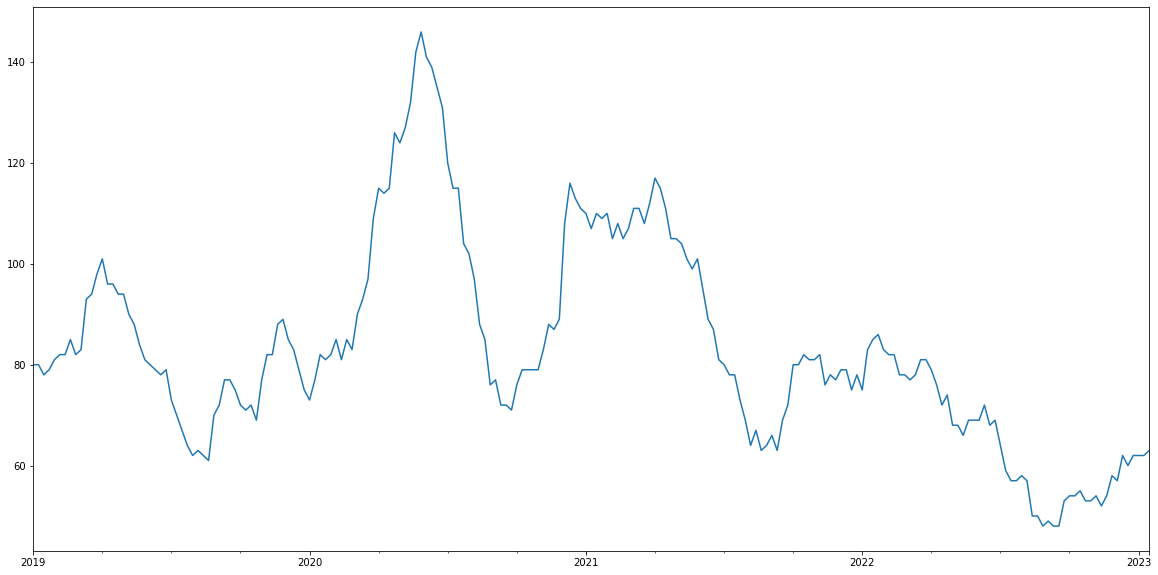

In [141]:
def show_diagram(df, timedelta=90, start_date="1/1/2019", baseline=1):
    raw = df.copy()
    
    d_start_date = pd.to_datetime(start_date) - pd.Timedelta(days=timedelta)
    raw = raw[raw["date"] >= d_start_date]
    
    time_index = pd.date_range(start_date, end=raw["date"].max(), freq="w")
    
    def number_authors(t):
        df = raw[(raw["date"] >= t - pd.Timedelta(days=timedelta)) & (raw["date"] <= t)]
        df = df[["user_id", "date"]]
        counts = df.groupby("user_id").count()
        
        return sum(counts["date"] > baseline)
    
    series = pd.Series(time_index.map(number_authors), index=time_index)
    
    series.plot(figsize=(20, 10))
    
show_diagram(d)